# Use this notebook to extract some of the needed data for training the model. Assuming the bathy data is downloaded from 01_get_data.ipynb, and the imagery is downloaded from Google Drive

In [134]:
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from scipy.interpolate import griddata

# Functions

In [49]:
def normalize(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

# Establish working directories

In [162]:
gdbfile='/mnt/d/eHydro/TC_01_BRT_20201225_XA/TC_01_BRT_20201225_XA.gdb'

In [163]:
gdblayers = fiona.listlayers(gdbfile)
gdblayers

['Bathymetry_Vector',
 'SurveyJob',
 'ElevationContour',
 'ElevationContour_ALL',
 'Channel_Availability',
 'ShoalPolygon',
 'SurveyPoint',
 'SPQ_Numbers',
 'Channel_Availability_Table',
 'version']

In [223]:
coords = []
depths = []

contours = gpd.read_file(gdbfile, layer="ElevationContour_ALL")  

for line, depth in zip(contours.geometry, contours['contourElevation']): 
    depth *= -1
    if line.geom_type == "LineString":
        # Single LineString
        coords.extend(list(line.coords))
        depths.extend([depth] * len(line.coords))
    elif line.geom_type == "MultiLineString":
        # Multi-part LineString
        for part in line.geoms:
            coords.extend(list(part.coords))
            depths.extend([depth] * len(part.coords))


# Define grid bounds and resolution
bounds = contours.total_bounds  # [minX, minY, maxX, maxY]
grid_x, grid_y = np.meshgrid(
    np.linspace(bounds[0], bounds[2], 500),  # 500 points along X-axis
    np.linspace(bounds[1], bounds[3], 500),  # 500 points along Y-axis
)

# Interpolate depth values onto the grid
grid_z = griddata(coords, depths, (grid_x, grid_y), method='nearest')  # Use 'linear' or 'nearest' if needed
grid_z = np.nan_to_num(grid_z, nan=np.nan)  # Replace NaN with NoData value

In [224]:
# Define raster resolution (grid size in meters)
resolution = 10  # Each pixel will cover a 10m x 10m area

# Create a transform for the raster
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3],
                        int((bounds[2] - bounds[0]) / resolution),  # Number of columns
                        int((bounds[3] - bounds[1]) / resolution))  # Number of rows

In [225]:
tif_file = '/mnt/d/eHydro/tiffs/TC_01_BRT_20201225_XA.tif'
reprojected_file = '/mnt/d/eHydro/TC_01_BRT_20201225_XA/TC_01_BRT_20201225_XA_reprojected.tif'

# Reproject to match bathymetry CRS
with rasterio.open(tif_file) as src:
    # Get bathymetry CRS
    bathy_crs = contours.crs

    # Calculate the transform and metadata for the new CRS
    transform, width, height = calculate_default_transform(
        src.crs, bathy_crs, src.width, src.height, *src.bounds
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": bathy_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Reproject and save the raster
    with rasterio.open(reprojected_file, "w", **new_meta) as dst:
        for i in range(1, src.count + 1):  # Loop through bands
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=bathy_crs,
                resampling=Resampling.cubic_spline
            )

print("Sentinel-2 raster reprojected successfully!")

with rasterio.open(reprojected_file) as src:
    meta = src.profile
    red = src.read(3)  # Red band
    green = src.read(2)  # Green band
    blue = src.read(1)  # Blue band
    tif_extent = src.bounds  # Get the bounding box for extent
    transform = src.transform
    extent = [tif_extent.left, tif_extent.right, tif_extent.bottom, tif_extent.top]

    rgb = np.dstack([normalize(red),normalize(green),normalize(blue)])

Sentinel-2 raster reprojected successfully!


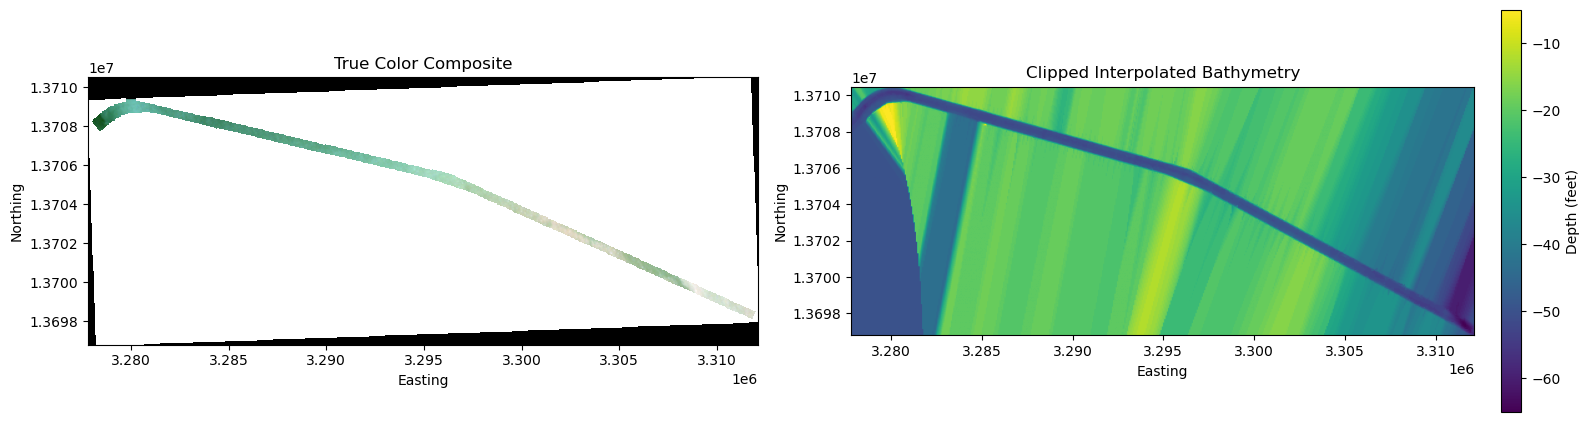

In [228]:
# Create a mask for valid (non-NaN) pixels in Sentinel-2
sentinel_mask = ~np.isnan(red) & ~np.isnan(green) & ~np.isnan(blue)  # Valid pixels in all bands

# Find the row/column indices of the valid mask
rows, cols = np.where(sentinel_mask)

# Calculate the bounding box in pixel indices
row_min, row_max = rows.min(), rows.max()
col_min, col_max = cols.min(), cols.max()

# Convert pixel indices to geospatial coordinates using the transform
from rasterio.transform import rowcol, xy

# Get bounds in geospatial coordinates
xmin, ymin = xy(transform, row_max + 1, col_min)  # Lower-left corner
xmax, ymax = xy(transform, row_min, col_max + 1)  # Upper-right corner

# Output the new bounds
sentinel_bounds = (xmin, xmax, ymin, ymax)

# Calculate indices for the bathymetry grid within the Sentinel bounds
x_indices = np.where((bounds[0] <= grid_x) & (grid_x <= bounds[2]))[0]
y_indices = np.where((bounds[1] <= grid_y) & (grid_y <= bounds[3]))[0]

# Subset the grid_z array to these indices
clipped_grid_z = grid_z[y_indices.min():y_indices.max() + 1, x_indices.min():x_indices.max() + 1]

# Update bounds to match the clipped grid
clipped_bounds = (xmin, xmax, ymin, ymax)

# Plot the bathymetry data next to the true color composite
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot True Color Composite (left)
axes[0].imshow(rgb, extent=extent)
axes[0].set_title("True Color Composite")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")

# Plot Clipped Bathymetry (right)
im = axes[1].imshow(
    clipped_grid_z,
    cmap="viridis",
    extent=clipped_bounds,
    origin="lower",
    vmin=np.nanmin(clipped_grid_z),
    vmax=np.nanmax(clipped_grid_z)
)
axes[1].set_title("Clipped Interpolated Bathymetry")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")

# Add color bar
cbar = fig.colorbar(im, ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("Depth (feet)")

plt.tight_layout()
plt.show()

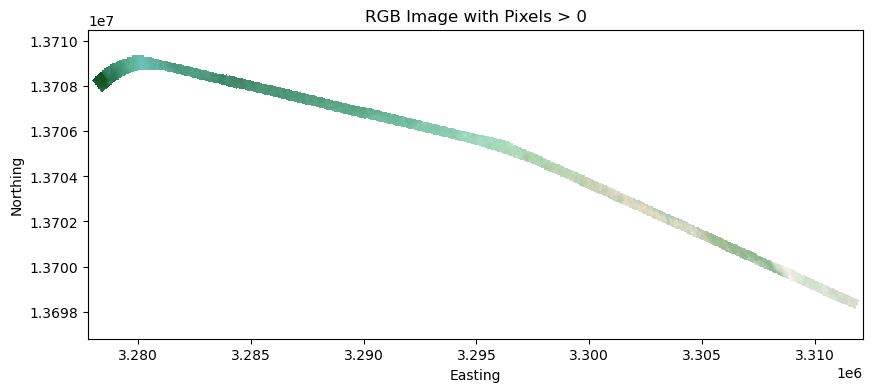

In [211]:
# Create a mask where all three bands (red, green, blue) are greater than 0
mask = (rgb > 0).all(axis=2)  # Mask shape will be (472, 1183)

# Apply the mask to each RGB channel
rgb_masked = np.zeros_like(rgb)  # Initialize an empty array with the same shape as `rgb`
rgb_masked[:] = np.nan           # Fill with NaN for invalid pixels
for i in range(3):               # Apply mask to each channel
    rgb_masked[:, :, i] = np.where(mask, rgb[:, :, i], np.nan)

# Plot the masked RGB image
plt.figure(figsize=(10, 8))
plt.imshow(rgb_masked, extent=extent)
plt.title("RGB Image with Pixels > 0")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()